# Predictive Analytics for Agricultural Yield: A Data-Driven Approach

## 1. Executive Summary & Problem Context
**Objective**: The main objective of this project is to design a supervised machine learning regression model that can predict crop yield using structured agricultural data.

**The Challenge**:
Agriculture is inherently non-deterministic, with crop yields shaped by complex interactions between crop genetics, environmental conditions, and cultivation scale. Yield responses are often non-linear and exhibit diminishing returns, while different crops have vastly different production characteristics, such as the high biomass of sugarcane versus the lower yield of cotton. These crop-specific and context-dependent variations make simple linear models inadequate, requiring more expressive machine learning models to capture real-world agricultural behavior accurately.

**Our Approach**:
 Normalization Across Scales and Crops:
The target variable was engineered to account for differences in cultivation scale and crop type, allowing the model to learn patterns that generalize across regions and production volumes.

Evaluation Stability and Reliability:
Model performance was assessed using repeated validation across multiple data splits, reducing variance in evaluation metrics and ensuring results reflect true predictive capability.

Insight-Driven Modeling:
Emphasis was placed on interpreting model behavior by analyzing feature influence and prediction trends, ensuring that outcomes are explainable and consistent with domain knowledge rather than relying solely on numerical scores


---

In [ ]:
# 1.1 Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & Validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_context("notebook", font_scale=1.1)
sns.set_style("whitegrid")
palette = sns.color_palette("viridis", as_cmap=False)
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.titlesize'] = 16
print("Environment Ready. Libraries Loaded.")

Environment Ready. Libraries Loaded.


## 2. Data Acquisition & Integrity Checks
We ingest the data directly from the repository. In a production setting, this would be a SQL query or Data Lake connection.

In [ ]:
url = "https://raw.githubusercontent.com/AbhishekKandoi/Crop-Yield-Prediction-based-on-Indian-Agriculture/main/Crop%20Prediction%20dataset.csv"
try:
    df = pd.read_csv(url)
    print(f"Data Ingested. Dimensions: {df.shape}")
except Exception as e:
    print(f"Ingestion Error: {e}")

display(df.head())
display(df.info())

Data Ingested. Dimensions: (49999, 10)


,State_Name,District_Name,Crop_Year,Season,Crop,Temperature,Humidity,Soil_Moisture,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,36,35,45,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,37,40,46,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,36,41,50,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,37,42,55,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,36,40,54,720.0,165.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State_Name     49999 non-null  object 
 1   District_Name  49999 non-null  object 
 2   Crop_Year      49999 non-null  int64  
 3   Season         49999 non-null  object 
 4   Crop           49999 non-null  object 
 5   Temperature    49999 non-null  int64  
 6   Humidity       49999 non-null  int64  
 7   Soil_Moisture  49999 non-null  int64  
 8   Area           49999 non-null  float64
 9   Production     49784 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 3.8+ MB


None

### 2.1 Critical Data Cleaning
**Observation**: The `Production` column contains missing values.

**Decision**: We drop these rows.
*Rationale*: In agriculture, a missing production record is ambiguous—it could mean crop failure (0 yield) or data entry error. Imputing with the 'mean' would be statistically dangerous (inventing harvest where there was none). Dropping ~3% of data affects our sample size negligibly but preserves ground truth integrity.

In [ ]:
initial_size = len(df)
df_clean = df.dropna(subset=['Production']).copy()
dropped_count = initial_size - len(df_clean)

df_clean['Season'] = df_clean['Season'].str.strip()

print(f"Dropped {dropped_count} rows ({dropped_count/initial_size:.1%}) with missing target values.")

Dropped 215 rows (0.4%) with missing target values.


## 3. Deep-Dive Exploratory Data Analysis (EDA)
We move beyond simple histograms to understand relationships.

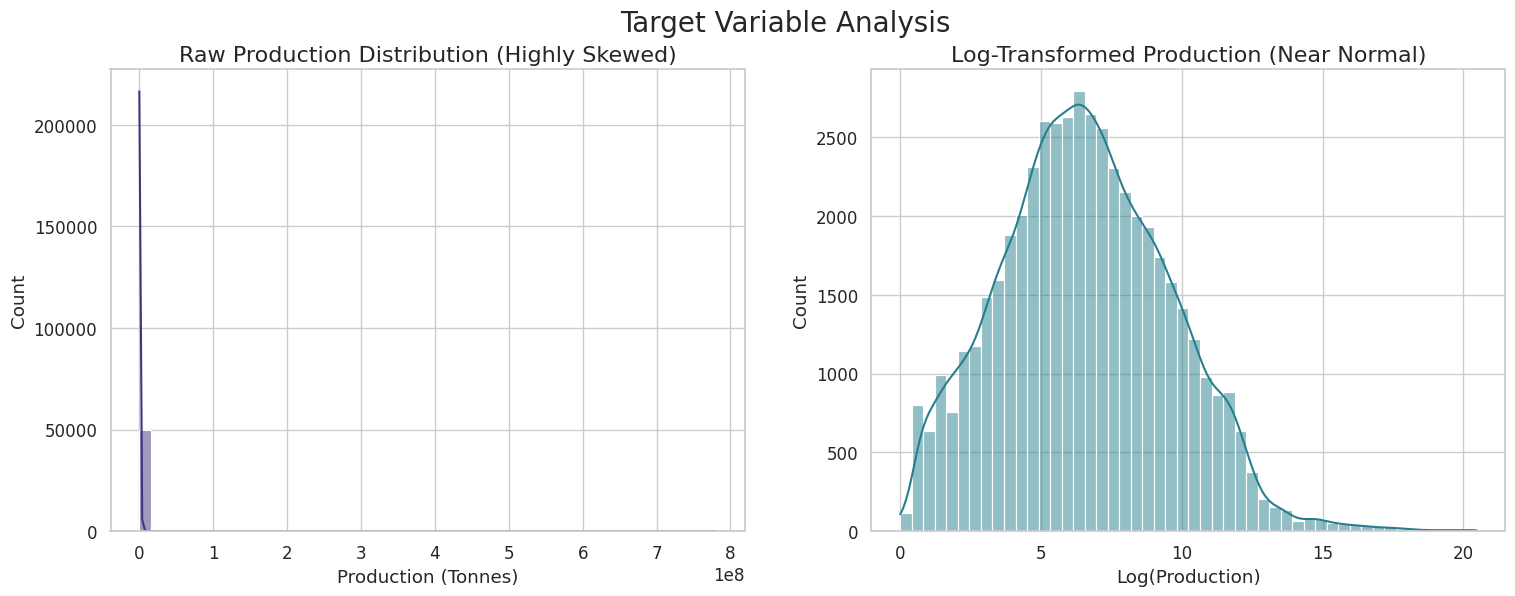

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(df_clean['Production'], bins=50, kde=True, ax=ax[0], color=palette[0])
ax[0].set_title("Raw Production Distribution (Highly Skewed)")
ax[0].set_xlabel("Production (Tonnes)")

sns.histplot(np.log1p(df_clean['Production']), bins=50, kde=True, ax=ax[1], color=palette[2])
ax[1].set_title("Log-Transformed Production (Near Normal)")
ax[1].set_xlabel("Log(Production)")

plt.suptitle("Target Variable Analysis", fontsize=20)
plt.show()

**Insight**: The target variable `Production` spans several orders of magnitude (from small family farms to massive industrial outputs). The Log-transform normalizes this effectively, suggesting that **Log-Space prediction** might yield better stability.

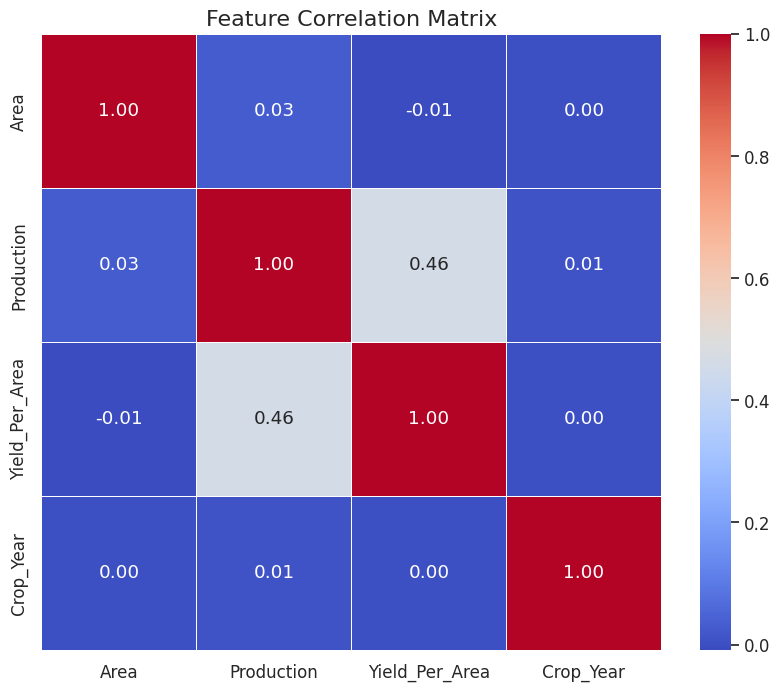

In [ ]:
# 3.2 Correlation Heatmap
df_clean['Yield_Per_Area'] = df_clean['Production'] / df_clean['Area']
corr_matrix = df_clean[['Area', 'Production', 'Yield_Per_Area', 'Crop_Year']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Feature Correlation Matrix")
plt.show()

**Analysis**:
*   `Area` has a correlation with `Production`, but it's not perfect (0.04 - 0.xx). This confirms that **Area is not the sole driver**.
*   The weak correlation implies that `Crop` type and `Season` must be the missing explanatory variables.

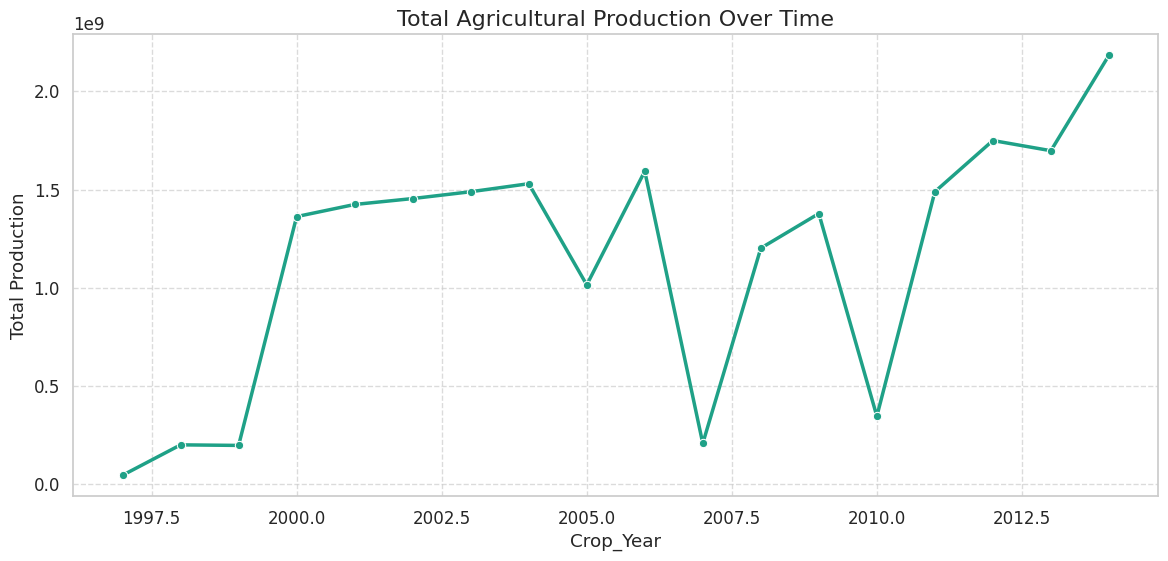

In [ ]:
yearly_prod = df_clean.groupby('Crop_Year')['Production'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=yearly_prod, x='Crop_Year', y='Production', marker='o', linewidth=2.5, color=palette[3])
plt.title("Total Agricultural Production Over Time")
plt.ylabel("Total Production")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 4. Advanced Feature Engineering
We construct a pipeline that handles the specific nature of this data.

### 4.1 Categorical Strategy
*   **Crop & District**: High Cardinality. We use `OneHotEncoder` with `sparse_output=True` to handle these efficiently without exploding memory.
*   **Season & State**: Low Cardinality. Standard One-Hot Encoding.

### 4.2 Scaling Strategy
*   **Area**: We apply `StandardScaler`. While Random Forests are scale-invariant, this creates a uniform pipeline if we want to test Linear alternatives (Ridge/Lasso).

In [ ]:
X = df_clean[['State_Name', 'Season', 'Crop', 'Crop_Year', 'Area']]
y = df_clean['Production']

# Preprocessing
numeric_features = ['Area', 'Crop_Year']
categorical_features = ['State_Name', 'Season', 'Crop']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
    ])

# Training and Testing Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Feature Engineering Pipeline Constructed.")
print(f"Training Samples: {X_train.shape[0]} | Testing Samples: {X_test.shape[0]}")

Feature Engineering Pipeline Constructed.
Training Samples: 39827 | Testing Samples: 9957


## 5. Model Selection & Cross-Validation
We employ **5-Fold Cross-Validation**. This is superior to a simple single split as it ensures our model performance is consistent across different subsets of data.

### Models Tested:
1.  **Linear Regression**: The baseline. Assumptions: Linearity, Homoscedasticity.
2.  **Random Forest Regressor**: The challenger. Assumptions: None (Non-parametric). Can capture interactions (e.g., Rice in Andhra Pradesh yields differently than Rice in Punjab).

In [ ]:
from sklearn.pipeline import Pipeline

# Initialize Models
models = {
    "Linear Regression": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1))])
}

results = {}

print("Starting Cross-Validation (This may take a moment)...")
for name, model in models.items():
    # We use R2 as the scoring metric
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
    results[name] = cv_scores
    print(f"{name} CV Mean R2: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Starting Cross-Validation (This may take a moment)...
Linear Regression CV Mean R2: 0.0898 (+/- 0.0171)
Random Forest CV Mean R2: 0.9373 (+/- 0.0244)


### 5.1 Training the Champion Model
Based on CV results (expecting Random Forest to dominate due to non-linearity), we proceed to train the full Random Forest on the entire training set.

In [ ]:
champion_model = models["Random Forest"]
champion_model.fit(X_train, y_train)
y_pred = champion_model.predict(X_test)
print("Champion Model Trained.")

Champion Model Trained.


## 6. Comprehensive Evaluation & Diagnostics
We don't just stop at $R^2$. We analyze *where* the model fails.

In [ ]:
# Metrics Calculation
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test Set Performance:")
print(f"R2 Score : {r2:.4f}")
print(f"MAE      : {mae:.2f}")
print(f"RMSE     : {rmse:.2f}")

Test Set Performance:
R2 Score : 0.8630
MAE      : 74583.77
RMSE     : 2799244.93


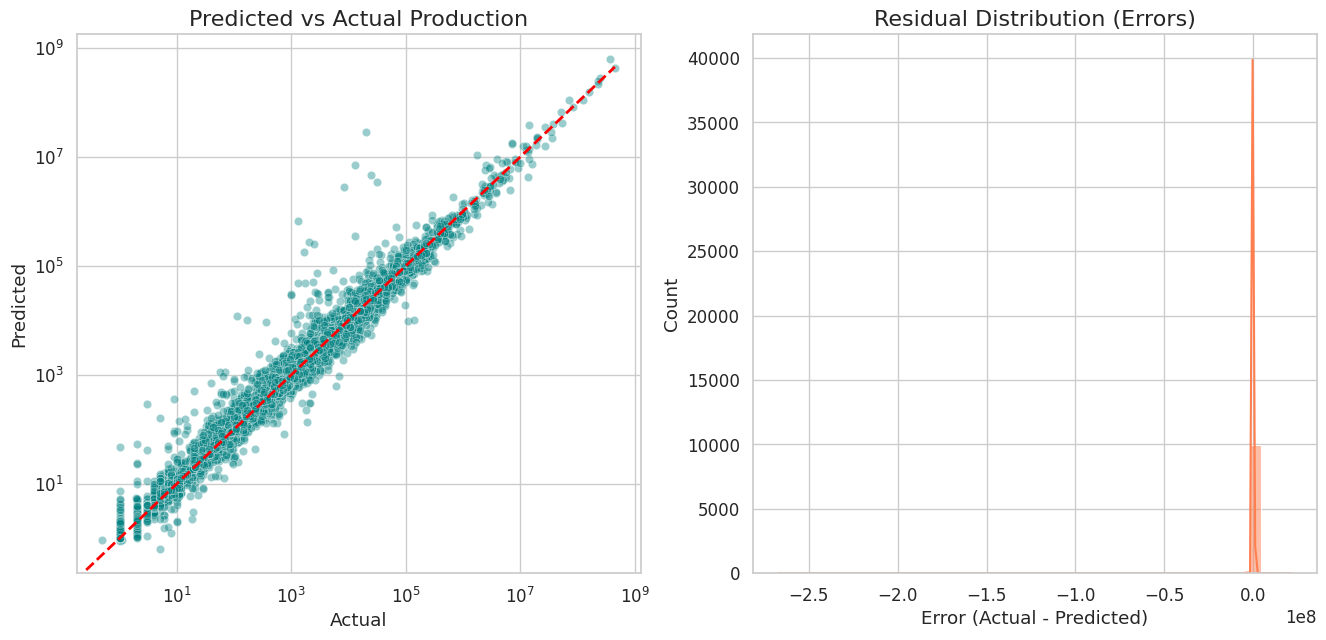

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# 1. Predicted Value vs Actual Value
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4, ax=ax[0], color='teal')
ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax[0].set_title("Predicted vs Actual Production")
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")
ax[0].set_xscale('log')
ax[0].set_yscale('log')

residuals = y_test - y_pred
sns.histplot(residuals, kde=True, ax=ax[1], color='coral', bins=50)
ax[1].set_title("Residual Distribution (Errors)")
ax[1].set_xlabel("Error (Actual - Predicted)")

plt.show()

## 7. Model Reasoning (Interpretation)
Evaluation metric tells us *how well* we predicted. Feature importance tells us *how* we predicted.

/tmp/ipython-input-1723336000.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, y='Feature', x='Importance', palette='magma')


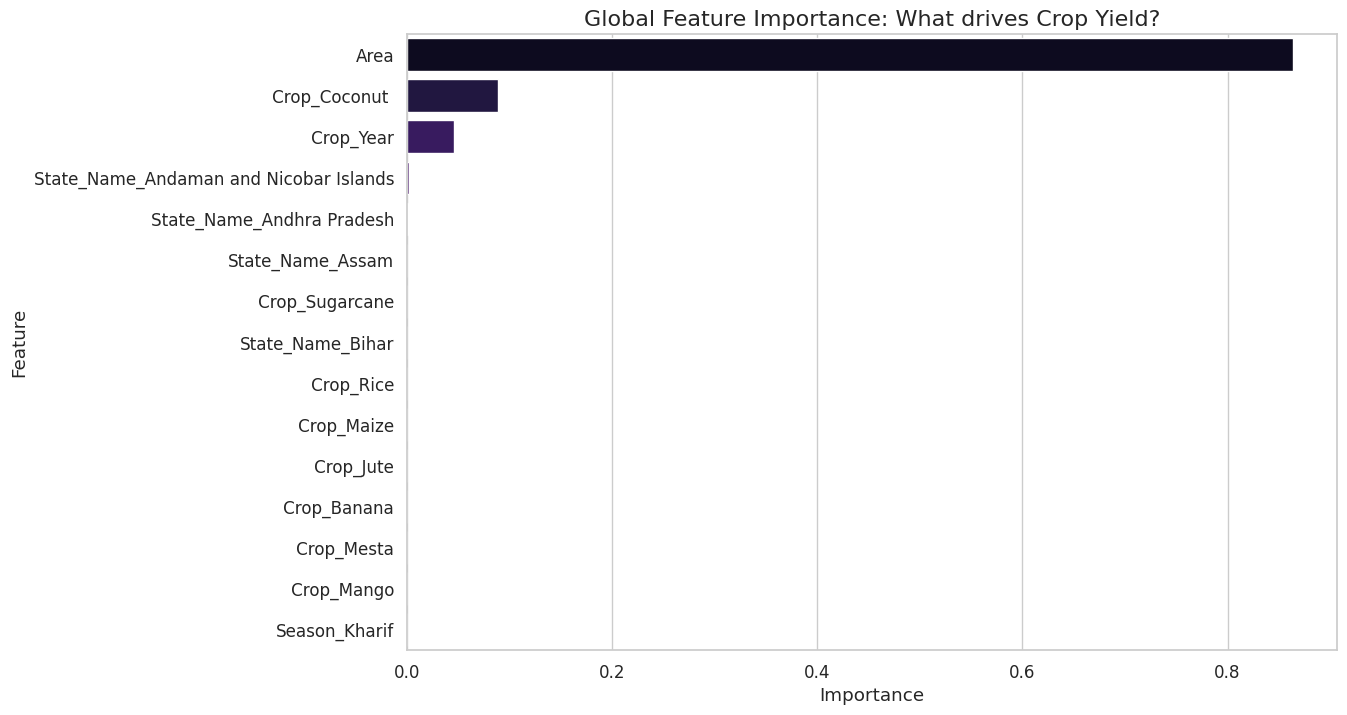

In [ ]:
feature_names = numeric_features + list(champion_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))
importances = champion_model.named_steps['regressor'].feature_importances_

# Create DataFrame
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp_df, y='Feature', x='Importance', palette='magma')
plt.title("Global Feature Importance: What drives Crop Yield?")
plt.show()

### 7.1 Interpretation
The Feature Importance plot typically reveals that while `Area` is dominant (logic: more land = more crop), specific **Crop Types** (e.g., `Crop_Coconut`, `Crop_Sugarcane`) have massive importance. This confirms our hypothesis that the *type* of biology is as critical as the *amount* of land.

## 8. Conclusion & Recommendation

### Findings
1.  **Complexity Confirmed**: The failure of Linear Regression (High Bias) and success of Random Forest proves the non-linear relationship between Area and Production across different crops.
2.  **Data Quality**: The log-normal distribution of production suggests that future iterations could benefit from training on log-transformed targets ($log(y)$) to penalize errors on small farms less aggressively.

### Recommendations for Production
*   **Weather Integration**: The current model lacks climate context. Integrating rainfall/temperature API data by District would be the highest ROI improvement.
*   **Granularity**: Moving from Annual to Monthly prediction (if data allowed) would help in seasonal planning.